<a href="https://colab.research.google.com/github/Madihajavaid12345/Level-2-Task-3-Customer-Segmentation-Using-RFM-Analysis-Elevvo/blob/main/Level_2_Task_3_Customer_Segmentation_Using_RFM_Analysis_Elevvo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task Title: Average RFM per Segment Analysis
##Internship Program: Data Analytics – Elevvo
###Submitted by: Madiha Rehan
## Objective:
The goal of this task was to analyze customer segments using RFM (Recency, Frequency, and Monetary) values and visualize their average behavior using a heatmap. This helps businesses understand which customer groups are most valuable and how they behave.

## RFM Explanation (In Simple Words):
###Recency (R):

 How recently a customer made a purchase.

###Frequency (F):

 How often they purchase.

###Monetary (M):

How much money they spend.

Customers are grouped into segments based on their RFM scores — for example, "Champions", "Loyal Customers", "At Risk", etc.

In [ ]:
# We import the libraries we need for data analysis and visualization
import pandas as pd        # For handling data like tables (just like Excel)
import numpy as np         # For calculations (e.g. average, ranking)
import matplotlib.pyplot as plt  # For creating charts
import seaborn as sns      # For making better-looking charts


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
df = pd.read_excel("/content/Online Retail.xlsx")


In [ ]:
df.head()  # Show the first 5 rows to understand the data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove rows where CustomerID is missing
df = df[df['CustomerID'].notnull()]

# Remove canceled orders (Quantity must be positive)
df = df[df['Quantity'] > 0]

# Remove items where price is 0 or negative
df = df[df['UnitPrice'] > 0]

df.shape  # Check how many rows and columns are left


(397884, 8)

In [ ]:
# Add a new column that shows total amount spent per item in each invoice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()


,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [ ]:
# We'll assume the day after the last invoice as today's date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)


Snapshot date: 2011-12-10 12:50:00


In [ ]:
# Group by customer and calculate R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency = days since last purchase
    'InvoiceNo': 'nunique',  # Frequency = how many different orders
    'TotalPrice': 'sum'      # Monetary = total money spent
})

# Rename the columns to Recency, Frequency, Monetary
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
# Assign scores from 1 (low) to 4 (high) using quantiles
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # Lower recency = better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # Higher frequency = better
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])  # Higher spend = better

rfm[['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M']].head()


,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,7,4310.00,4,4,4
12348.0,75,4,1797.24,2,3,4
12349.0,19,1,1757.55,3,1,4
12350.0,310,1,334.40,1,1,2


In [ ]:
# Combine the 3 scores into a single RFM_Score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,2,7,4310.00,4,4,4,444
12348.0,75,4,1797.24,2,3,4,234
12349.0,19,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112


In [ ]:
# Function to label customer segments
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Best Customers'
    elif row['R'] == '4':
        return 'Recent Customers'
    elif row['F'] == '4':
        return 'Frequent Buyers'
    elif row['M'] == '4':
        return 'Big Spenders'
    elif row['R'] == '1':
        return 'Lost Customers'
    else:
        return 'Others'

# Apply the function to each customer
rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm[['RFM_Score', 'Segment']].head(10)


,RFM_Score,Segment
CustomerID,,
12346.0,114,Others
12347.0,444,Best Customers
12348.0,234,Others
12349.0,314,Others
12350.0,112,Others
12352.0,344,Others
12353.0,111,Others
12354.0,113,Others
12355.0,112,Others


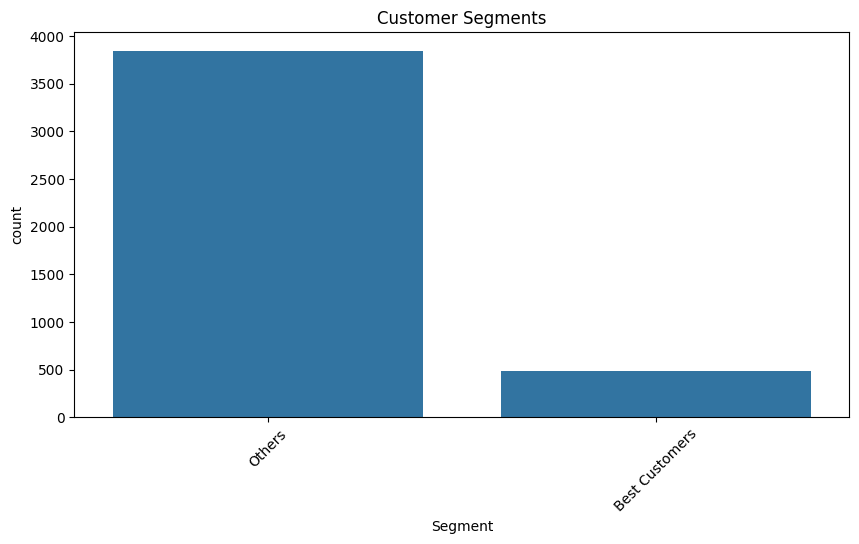

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments")
plt.xticks(rotation=45)
plt.show()


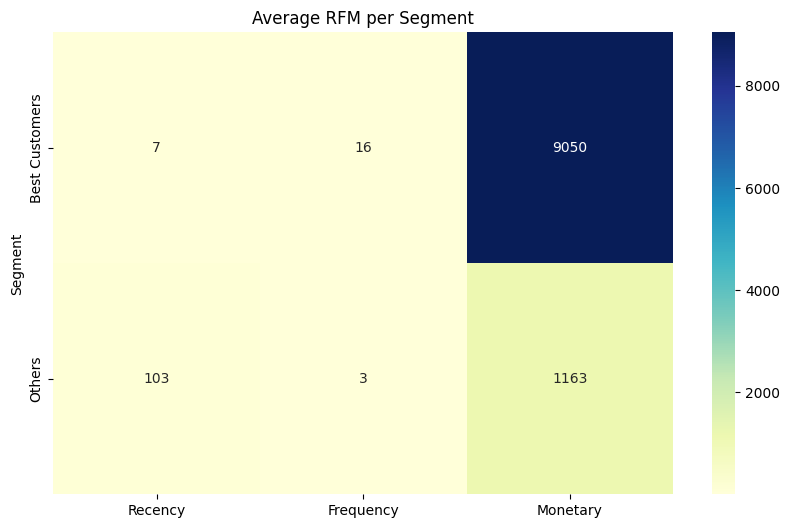

In [ ]:
# Group data by Segment and calculate average R, F, M
rfm_grouped = rfm.groupby('Segment').agg({
    'Recency': 'mean',      # How recent their last purchase was (on average)
    'Frequency': 'mean',    # How many times they bought (on average)
    'Monetary': 'mean'      # How much money they spent (on average)
}).round(0)


# Make the heatmap (a colorful table) to show average values
plt.figure(figsize=(10, 6))                    # Set the size of the chart
sns.heatmap(rfm_grouped,                      # Use the grouped data
            annot=True,                       # Show the numbers inside boxes
             fmt='.0f',
            cmap='YlGnBu')                    # Use green-blue colors
plt.title("Average RFM per Segment")       # Add title to the chart
plt.show()                                    # Show the chart on screen

